True Label = 1 | Predicted = 1


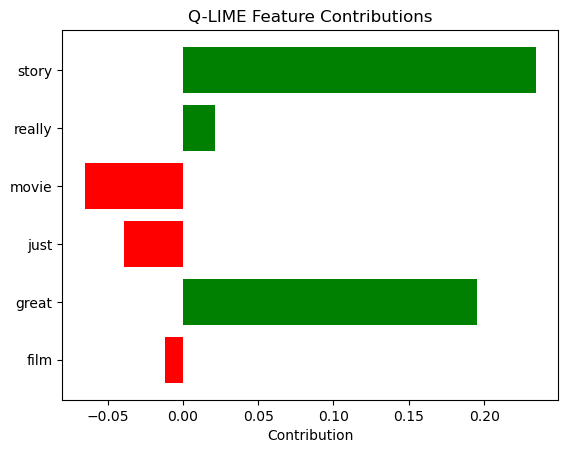

In [19]:
import time
import random
import re
from IPython.display import display, HTML
import matplotlib.pyplot as plt

import numpy as np
import pennylane as qml
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

##############################################################################
# PART 0: DATA LOADING AND PREPROCESSING
##############################################################################

def clean_text(text):
    """Remove HTML tags and convert to lowercase."""
    return re.sub(r'<.*?>', '', text).lower()

def load_imdb_subset(num_samples=1000, min_df=2, max_features=20):
    """Load and preprocess IMDb data."""
    data = load_files("./aclImdb/train", categories=['pos','neg'],
                      encoding="utf-8", decode_error="replace")
    X_text, y = data.data, data.target

    X_text = [clean_text(txt) for txt in X_text]
    idx = np.arange(num_samples)
    np.random.shuffle(idx)
    X_text = [X_text[i] for i in idx]
    y = y[idx]

    X_train, X_test, y_train, y_test = train_test_split(
        X_text, y, test_size=0.2, random_state=42
    )

    vectorizer = CountVectorizer(binary=True, stop_words='english',
                                 min_df=min_df, max_features=max_features)
    vectorizer.fit(X_train)
    return X_train, X_test, y_train, y_test, vectorizer

##############################################################################
# PART 1: QUANTUM LIME IMPLEMENTATION
##############################################################################

def classical_classifier(features, weights):
    """Simple logistic: dot(features, weights), then sigmoid."""
    score = np.dot(features, weights)
    return 1 / (1 + np.exp(-score))

def encode_and_flip(features, flip_index=None):
    """Encode features into a quantum circuit, flipping one bit."""
    dev = qml.device("default.qubit", wires=len(features), shots=None)

    @qml.qnode(dev)
    def circuit():
        for i, f in enumerate(features):
            theta = 0.0 if i == flip_index and f == 1 else f * (np.pi / 2)
            qml.RY(theta, wires=i)
        return qml.probs(wires=range(len(features)))

    return circuit()

def measure_and_map_to_classical(features, flip_index=None):
    """Measure the quantum state, get a single classical bitstring."""
    probs = encode_and_flip(features, flip_index)
    measured_state = np.random.choice(len(probs), p=probs)
    bin_string = f"{measured_state:0{len(features)}b}"
    return [int(bit) for bit in bin_string]

def quantum_lime_explanation(features, weights):
    """Run Q-LIME, flipping bits from 1->0 and measuring impact."""
    original_pred = classical_classifier(features, weights)
    contributions = np.zeros(len(features))

    for i, val in enumerate(features):
        if val == 1:
            new_vec = measure_and_map_to_classical(features, flip_index=i)
            new_pred = classical_classifier(new_vec, weights)
            contributions[i] = original_pred - new_pred

    return contributions

##############################################################################
# PART 2: VISUALIZATION
##############################################################################

def visualize_q_lime(features, contributions, vectorizer):
    """Visualize Q-LIME feature contributions as a bar graph."""
    feature_names = vectorizer.get_feature_names_out()
    non_zero_indices = [i for i, c in enumerate(contributions) if abs(c) > 1e-7]
    
    words = [feature_names[i] for i in non_zero_indices]
    values = [contributions[i] for i in non_zero_indices]

    colors = ['green' if v > 0 else 'red' for v in values]
    plt.barh(words, values, color=colors)
    plt.xlabel("Contribution")
    plt.title("Q-LIME Feature Contributions")
    plt.show()

##############################################################################
# PART 3: RUN Q-LIME ON A SINGLE TEXT
##############################################################################


def highlight_text_with_contributions(text, contributions, vectorizer, top_n=5):
    """
    Highlight top-N words in the text based on Q-LIME contributions.
    Green for positive contributions, red for negative contributions.
    """
    feature_names = vectorizer.get_feature_names_out()
    non_zero_indices = [i for i, c in enumerate(contributions) if abs(c) > 1e-7]

    # Get top-N contributing features
    top_contributors = sorted(
        non_zero_indices, key=lambda i: abs(contributions[i]), reverse=True
    )[:top_n]

    word_colors = {}
    for idx in top_contributors:
        word = feature_names[idx]
        if contributions[idx] > 0:
            word_colors[word] = "green"
        else:
            word_colors[word] = "red"

    # Highlight words in the text
    highlighted_text = []
    for word in text.split():
        clean_word = re.sub(r'[^\w]', '', word.lower())  # Remove punctuation
        if clean_word in word_colors:
            color = word_colors[clean_word]
            highlighted_text.append(f'<span style="color:{color}; font-weight:bold;">{word}</span>')
        else:
            highlighted_text.append(word)

    return " ".join(highlighted_text)

def run_q_lime_example_with_html():
    # Load data
    X_train, X_test, y_train, y_test, vectorizer = load_imdb_subset(
        num_samples=500,
        min_df=1,
        max_features=10
    )

    # Train classifier
    clf = LogisticRegression()
    X_train_bow = vectorizer.transform(X_train)
    clf.fit(X_train_bow, y_train)

    logistic_weights = clf.coef_[0]

    # Pick one test sample
    idx = np.random.randint(0, len(X_test))
    text_sample = X_test[idx]
    true_label = y_test[idx]

    #print(f"TEXT SAMPLE:\n{text_sample}")
    print(f"True Label = {true_label} | Predicted = {clf.predict(vectorizer.transform([text_sample]))[0]}")

    # Convert text to binary feature vector
    bow = vectorizer.transform([text_sample]).toarray()[0]

    # Run Q-LIME
    contributions_qlime = quantum_lime_explanation(bow, logistic_weights)

    # Visualize contributions
    visualize_q_lime(bow, contributions_qlime, vectorizer)

    # Highlight text and display it
    highlighted_html = highlight_text_with_contributions(text_sample, contributions_qlime, vectorizer)
    display(HTML(f"<div style='font-size:16px;'>{highlighted_html}</div>"))

##############################################################################
# MAIN
##############################################################################

if __name__ == "__main__":
    run_q_lime_example_with_html()
    #run_q_lime_example()